# Izdvajanje tonova

Sledeći primer demonstrira kako se Furijeove transformacije mogu iskoristiti u prepoznavanje zvučnih tonova.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from IPython.display import Audio

Izbor pojedinačnih brojeva na telefonskoj tastaturi rezultira pratećim zvučnim signalom. Svaki od signala koji se emituje je zanimljivog matematičkog oblika $x(t)=cos(2\pi f_1 t)+cos(2\pi f_2 t)$ pri čemu je kombinacija frekvencija za svaki taster određena standardizovanom tabelom navedenom niže. <img src='assets/keypad_frequences.png'>

Tako je, recimo, izbor tastera 5 praćen signalom oblika $x(t)=cos(2\pi \cdot 770 \cdot t) + cos(2\pi \cdot 1336 \cdot t)$.

Informacije o frekvencijama koje se koriste u zvučnim signalima ćemo sačuvati u rečniku koji će nam omogućiti lak pristup.

In [3]:
F1 = np.array([697, 770, 852, 941])
F2 = np.array([1209, 1336, 1477, 1633])
tones = {
    '1': (0, 0),
    '2': (0, 1),
    '3': (0, 2),
    '4': (1, 0),
    '5': (1, 1),
    '6': (1, 2),
    '7': (2, 0),
    '8': (2, 1),
    '9': (2, 2),
    '0': (3, 1),
    '*': (3, 0),
    '#': (3, 2),
    'A': (0, 3),
    'B': (1, 3),
    'C': (2, 3),
    'D': (3, 3)
}
for number, indexes in sorted(tones.items()):
    print('%s: %dHz %dHz' % (number, F1[indexes[0]], F2[indexes[1]]))

#: 941Hz 1477Hz
*: 941Hz 1209Hz
0: 941Hz 1336Hz
1: 697Hz 1209Hz
2: 697Hz 1336Hz
3: 697Hz 1477Hz
4: 770Hz 1209Hz
5: 770Hz 1336Hz
6: 770Hz 1477Hz
7: 852Hz 1209Hz
8: 852Hz 1336Hz
9: 852Hz 1477Hz
A: 697Hz 1633Hz
B: 770Hz 1633Hz
C: 852Hz 1633Hz
D: 941Hz 1633Hz


Sledeća funkcija će nam pomoći da izlistane zvučne signale i generišemo. Njeni argumenti će biti broj tastera za koji želimo da generišemo zvuk, dužina trajanja zvučnog signala izražena u sekundama i frekvencija uzorkovanja signala. Funkcija će koristiti i globalni rečnik `tones` sa informacijama o tonovima.

In [4]:
def tone(number, duration, Fs):
    indexes = tones[number]
    f1 = F1[indexes[0]]
    f2 = F2[indexes[1]]

    t = np.arange(0, duration, 1 / Fs)
    return np.cos(2 * np.pi * f1 * t) + np.cos(2 * np.pi * f2 * t)

Opredelićemo se da u daljem radu frekvencija uzorkovanja bude 8000Hz.

In [5]:
Fs = 8000

Sada možemo da čujemo i zvuk koji prati izbor tastera 5 u trajanju od 2 sekunde.

In [8]:
keypad_5 = tone('9', 2, Fs)

In [9]:
Audio(data=keypad_5, rate=Fs)

Funkcija `dial_number` će nam pomoći da spojimo izbore nekoliko tastera u jedan zvučni signal. 

In [10]:
def dial_number(numbers, tone_duration, Fs):
    data = [tone(n, tone_duration, Fs) for n in numbers]
    return np.hstack(data)

Sada možemo da ispratimo kako zvuči izbor broja `0049176854864321` (ukupno 16 cifara).

In [11]:
keypad_combination = dial_number('0049176854864321', 0.2, Fs)

In [12]:
Audio(data=keypad_combination, rate=Fs) 

Zadatak kojim dalje želimo da istažimo je kako prepoznati odabrane cifre na osnovu zadatog zvučnog signala broja. Ideja je da to uradimo razlaganjem zvukova pojedinačnih cifara u frekvencijskom spektru i prepoznavanjem definisanih kombinacija. Zadatak će ipak biti izazovan!

Funkcija `transform` će objediniti korake izračunavanja Furijeovih koeficijenata i njihovog preraspoređivanja. Njeni argumenti će biti vrednosti zvučnog signala `data` i dužina zvučnog signala `length`. Dodatni argument dužine će nam omogućiti da, po potrebi, signal dopunimo nulama. 

In [13]:
def transform(data, length=None):
    if length is None:
        length = len(data)
    
    # Ukoliko se funkciji fft prosledi kao drugi argument duzina veca od duzine uzorkovanog signala
    # podrazumevano se vrsi dopuna nulama.
    return np.fft.fftshift(np.fft.fft(data, length))

Funkcija `mark_possible_tones` će nam pomoći da grafički ispratimo koliko su frekvencije koje budemo dobijali blizu frekvencijama $F1$ i $F2$ koje se kombinuju da bi se dobili prateći tonovi cifara.

In [14]:
def mark_possible_tones(F1, F2):
    for f in F1:
        plt.axvline(f, color='r')
    for f in F2:
        plt.axvline(f, color='g')

Ideju koju ćemo koristiti ćemo demonstrirati na izboru tastera `*`. Prvo ćemo generisati odgovarajući zvučni signal, a potom odrediti Furijeove koeficijente i frekvencije frekvencijskog spektra. 

In [15]:
data = tone(number='*', duration=1e-2, Fs=Fs)

In [16]:
N = len(data)

In [17]:
coefficients = transform(data)

In [18]:
freq = np.arange(-Fs/2, Fs/2, Fs/N)

Zatim ćemo generisati grafik ovog signala.

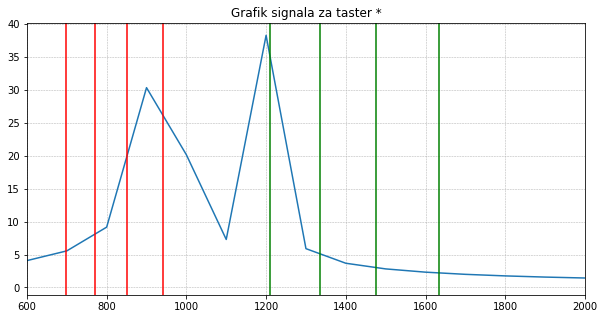

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(freq, np.abs(coefficients))
mark_possible_tones(F1, F2)
plt.xlim(600, 2000)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.title('Grafik signala za taster *')
plt.show()

Možemo primetiti da je desni pik signala vrlo blizu frekvencije 1209Hz, dok je levi pik između frekvencija 852Hz i 941Hz i ne može se jasno odrediti. Zato ćemo probati da dopunimo signal tj. uzorak kojim raspolažemo nulama i da preciznije očitamo frekvencije. Signal ćemo dopuniti sa $7\cdot N$ nula.

In [20]:
padding = 7*N
data_padded = np.hstack([data, np.zeros(padding)])
N_padded = len(data_padded)

In [21]:
coefficients_padded = transform(data_padded)
freq_padded = np.arange(-Fs/2, Fs/2, Fs/N_padded)

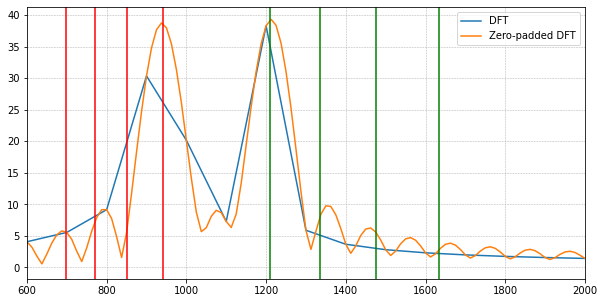

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(freq, np.abs(coefficients), label='DFT')
plt.plot(freq_padded, np.abs(coefficients_padded), label='Zero-padded DFT')
mark_possible_tones(F1, F2)
plt.xlim(600, 2000)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(loc='best')
plt.show()

Sa ovako dobijenog grafika prateći pikove dopunjenog signala možemo jasno očitati frekvencije 941Hz i 1209Hz i zaključiti da je reč o zvezdici. Ovaj pristup ćemo pratiti i u daljem radu: svaki od izdvojenih uzoraka signala ćemo dopuniti nulama, a potom odrediti frekvencijski spektar. Za finalnu kombinaciju frekvencija odabraćemo najveću među nižim i najmanju među višim prepoznatim frekvencijama. 

Funkcija `estimate_keypad` sumira logiku koju smo opisali i za zadati ton jednog tastera daje kao rezultat vrednost prepoznatog tastera.

In [23]:
def estimate_keypad(sound, Fs):
    
    # odredjujemo duzinu zadatog signala 
    N = len(sound)

    
    # vrsimo dopunu signala nulama i odredjujemo duzinu dopunjenog signala
    padding = 7*N
    sound_padded = np.hstack([sound, np.zeros(padding)])
    N_padded = len(sound_padded)
    
    # zatim kreiramo frekvencijski spektar i odredjujemo Furijeove koeficijente
    freq_zero_padded = np.arange(-Fs/2, Fs/2, Fs/N_padded) 
    coefficients_padded  = np.abs(transform(sound_padded))
    
    
    # za svaku od raspolozivih frekvencija iz F1 i F2 proveravamo koliko su blizu frekvencijskom spektru:
    # pronalazimo indekse onih frekvencija spektra koje su najblize definisanim frekvencijama
    freq_ind_lower = np.array([np.argmin(np.abs(freq_zero_padded - freq)) for freq in F1])
    freq_ind_higher = np.array([np.argmin(np.abs(freq_zero_padded - freq)) for freq in F2])
    
    # zatim izdvajamo vrednosti amplituda izdvojenih frekvencija-kandidata
    amplitude_lower = coefficients_padded[freq_ind_lower] 
    amplitude_higher = coefficients_padded[freq_ind_higher]
    
    # i biramo onu frekvenciju (tj. njen indeks) za koju je vrednost amplitude najveca
    f1_ind = np.argmax(amplitude_lower)
    f2_ind = np.argmax(amplitude_higher)
    
    # na kraju, iz tabele sa tonovima mozemo da vratimo prepoznati taster
    return [t[0] for t in tones.items() if t[1] == (f1_ind, f2_ind)][0]

Možemo proveriti da li osmišljena funkcija dobro radi zadavanjem testnih tastera.

In [24]:
keypad = '7'
duration = 1/100
sound = tone(keypad, duration, Fs)
estimated_keypad = estimate_keypad(sound, Fs)
print('Zvuk odgovara tasteru %s (pravi taster je %s).' % (keypad, estimated_keypad))

Zvuk odgovara tasteru 7 (pravi taster je 7).


Funkcija `estimate_number` će nam pomoći da ocenimo izbor celog broja.  Ona će koristiti prethodno implementiranu funkciju `estimate_keypad`. 

In [25]:
def estimate_number(sound, tone_duration, Fs):
    
    # odredjujemo broj uzoraka po jednom tasteru 
    N_per_tone = int(Fs*tone_duration)

    # zatim prerasporedjujemo uzorke tako da svaki taster ima N_per_tone uzoraka 
    tones = sound.reshape((-1, N_per_tone))
    
    # i dalje za svaki uzorak tastera radimo ocenu tastera 
    estimated = [estimate_keypad(tones[i,:], Fs) for i in range(tones.shape[0])]
    
    return "".join(estimated)

Možemo proveriti i ovu funkciju zadavanjem testnih brojeva.

In [26]:
tone_duration = 1 / 100
number = '0123456789ABCD#*'
sound = dial_number(number, tone_duration, Fs)
estimated_number = estimate_number(sound, tone_duration, Fs)
print('Zvuk odgovara broju %s (tacan broj je %s)' % (number, estimated_number))
print('Predlog je tacan: ', number == estimated_number)

Zvuk odgovara broju 0123456789ABCD#* (tacan broj je 0123456789ABCD#*)
Predlog je tacan:  True


Ako skratimo dužinu trajanja pojedinačnih tonova, prepoznavanje postaje teže.

In [27]:
tone_duration = 1 / 400
number = '1123456789ABCD#*'
sound = dial_number(number, tone_duration, Fs)
estimated_number = estimate_number(sound, tone_duration, Fs)
print('Zvuk odgovara broju %s (tacan broj je %s)' % (number, estimated_number))
print('Predlog je tacan: ', number == estimated_number)

Zvuk odgovara broju 1123456789ABCD#* (tacan broj je 1123556589ABCD#*)
Predlog je tacan:  False


Uprkos dopuni nulama, funkcija ne može da razlikuje bliske frekvencije pa je predloženi broj pogrešan. Razlog za ovo je što je period uzorkovanja ne dozvoljava dovoljno dobru spektralnu rezoluciju. 

Možemo proveriti kako se ponaša funkcija za prepoznavanje pojedinačnih tonova ukoliko se signalu doda šum iz normalne raspodele. 

In [28]:
def estimate_keypad_with_noise(keypad, sigma, duration, plot=False):
    
    sound = tone(keypad, duration, Fs)
    
    sound_with_noise = sound + sigma*np.random.randn(len(sound))
    estimated_kypad = estimate_keypad(sound_with_noise, Fs)
    
    # ukoliko je naveden parametar za iscrtavanje mozemo prikazati grafik u vremenskom domenu
    # i grafik signala dopunjenog nulama u frekvencijskom domenu
    if plot: 
        t = np.arange(0, duration, 1/Fs)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        ax1.plot(t, sound, label='Ulazni zvuk')
        ax1.plot(t, sound_with_noise, label='Zvuk sa sumom')
        ax1.set_xlim(0, 0.01)
        ax1.legend(loc='best')
        ax1.set_title('Zvuk')

        mark_possible_tones(F1, F2)
        
        padding = 7*N
        sound_with_noise_padded = np.hstack([sound_with_noise, np.zeros(padding)])
        N_padded = len(sound_with_noise_padded)

        coefficients_padded = np.abs(transform(sound_with_noise_padded))
        freq_padded = np.arange(-Fs/2, Fs/2, Fs/N_padded)

        ax2.plot(freq_padded, 20*np.log10(coefficients_padded))
        ax2.set_xlim(600, 2000)
        ax2.set_title('Frekvencijski spektar na logaritamskoj skali')

        plt.show()

    return estimated_kypad 


In [29]:
keypad = 'A'
sigma = 10 
duration = 1 
estimated_keypad = estimate_keypad_with_noise(keypad, sigma, duration)

print('Zvuk odgovara tasteru %s (pravi taster je %s).' % (keypad, estimated_keypad))
print('Predlog je tacan: ', keypad == estimated_keypad)

Zvuk odgovara tasteru A (pravi taster je A).
Predlog je tacan:  True


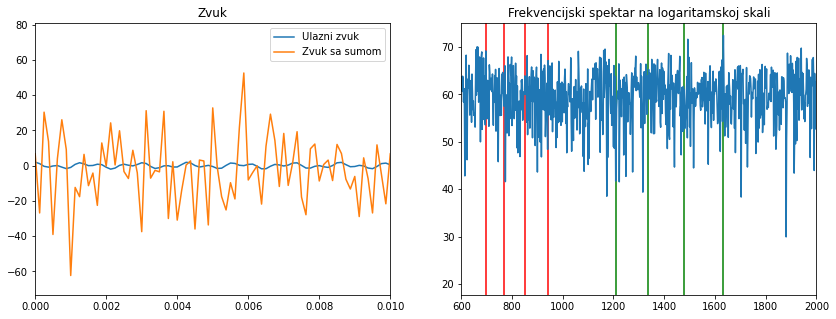

Zvuk odgovara tasteru A (pravi taster je A).
Predlog je tacan:  True


In [30]:
keypad = 'A'
sigma = 20 
duration = 0.5 
plot = True
estimated_keypad = estimate_keypad_with_noise(keypad, sigma, duration, plot)

print('Zvuk odgovara tasteru %s (pravi taster je %s).' % (keypad, estimated_keypad))
print('Predlog je tacan: ', keypad == estimated_keypad)

Možemo zaključiti da je sam algoritam imun na prisustvo šuma.